# Tarjeta de datos 2

<hr style="border: none; border-top: 2px solid #ccc;" />

### Hipótesis 2: "Existe una relación entre el porcentaje de viviendas de bajo consumo o esporádicas, de viviendas de consumo medio y de viviendas de alto consumo de una provincia y su tendencia a adoptar dispositivos de energía renovable"

Las viviendas de bajo consumo o esporádicas suelen corresponder a residencias secundarias, utilizadas principalmente durante periodos vacacionales o de forma ocasional. Debido a esto, las provincias con mayor porcentaje de este tipo de residencias suelen tener menor tendencia a adquirir dispositivos de energías renovables debido al poco tiempo que sus propietarios pasan en ellas.

Por otro lado, en las viviendas de alto consumo, sus propietarios suelen tener un poder adquisitivo mayor, y generalmente, prefieren contratar la electricidad a lidiar con los posibles problemas técnicos de este tipo de instalaciones.

Por último, las viviendas de consumo medio representan un equilibrio entre los costes y beneficios de las energías renovables. Por ello, la instalación de dispositivos de energía renovable puede ser una opción atractiva para los propietarios, ya que permite reducir gastos energéticos de manera significativa a medio y largo plazo.

<hr style="border: none; border-top: 1px solid #ccc;" />

### Preparación del entorno

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
import os
import scipy
import seaborn as sns

GOLD_DATA_PATH = os.path.join("..","..","data","gold")

### Datos

In [3]:
h2_df = pd.read_csv(os.path.join(GOLD_DATA_PATH, "data_card_2_df.csv"), sep = ";", encoding='latin')
h2_df.head()

,Provincias,Indice de viviendas renovables,Indice de viviendas bajo consumo,Indice de viviendas medio consumo,Indice de viviendas alto consumo
0,Albacete,4.314062,16.455392,49.556800,3.410094
1,Alicante/Alacant,4.036060,17.315108,46.869125,4.043834
2,Almería,6.713842,14.252022,47.126887,4.279526
3,Araba/Álava,10.445424,14.195114,65.471842,1.313018
4,Asturias,5.031368,15.586008,52.933971,2.967485


A continuación, calculamos las correlaciones entre las distintas variables del dataframe.

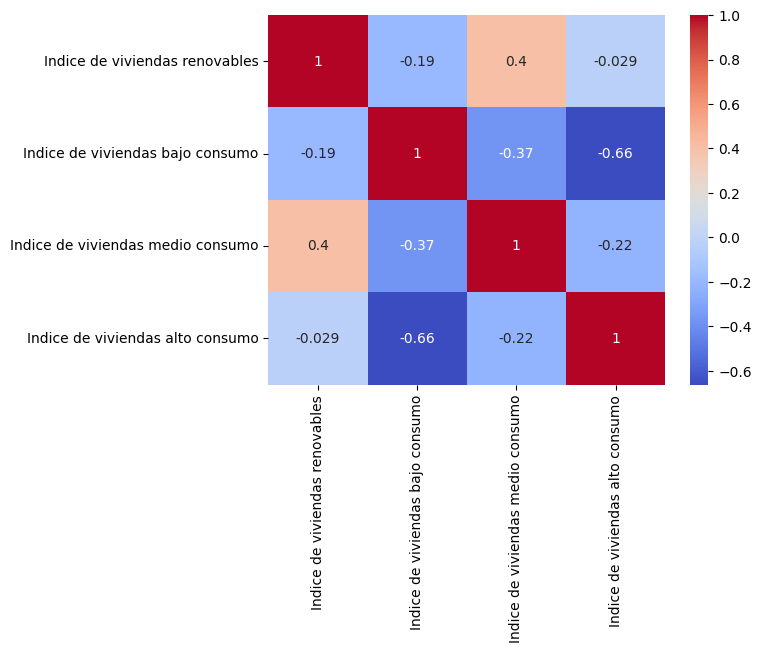

In [4]:
# Eliminar la columna provincias
h2_df_corr = h2_df.drop(columns=['Provincias'])

corr_matrix = h2_df_corr.corr()
sns.heatmap(corr_matrix, cmap='coolwarm', annot=True)
plt.show()

Una vez mostradas las correlaciones entre variables a través de una matriz de correlación, se puede llegar a las siguientes conclusiones:

- Existe una alta correlación negativa entre el **ìndice de viviendas de bajo consumo** y el **índice de viviendas de alto consumo**. 

- Existe una pequeña correlación (0.4) entre el **índice de viviendas de medio consumo** y el **índice de viviendas con algún dispositivo de energía renovable**.

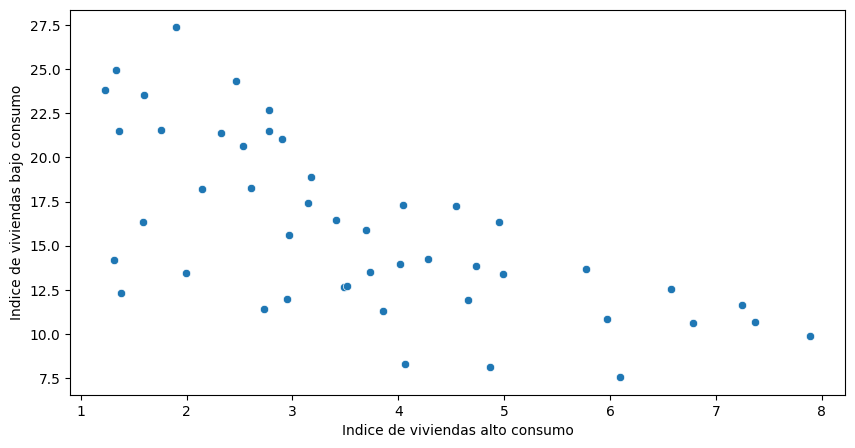

In [5]:
plt.figure(figsize=(10, 5))
sns.scatterplot(x='Indice de viviendas alto consumo', y='Indice de viviendas bajo consumo', data=h2_df)
plt.show()

Con este gráfico se quiere visualizar la relación entre el **ìndice de viviendas de bajo consumo** y el **índice de viviendas de alto consumo** debido a su alta correlación.

### Clustering

En este paso, vamos a hacer un clustering con K-Means. Se ha decidido utilizar este tipo de clustering debido a los siguientes motivos:

- **Facilidad de interpretación**: Este tipo de clustering es más fácil de interpretar. A diferencia del clustering jerárquico, no tenemos que analizar la estructura de ramificación de los dendogramas, lo que facilita el entendimiento.

- **Exploración de datos**: El clustering normalmente no se suele usar como validación de hipótesis, sino que, su objetivo es explorar los datos, identificar patrones e intentar obtener datos útiles mediante la interpretación de este. Se ha decidido utilizar `K-means`debido a su simplicidad, no solo de interpretar resultados, sino que también de obtener el número óptimo de clusters mediante el método del codo.

In [6]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

Debido a que la *escala* de cada una de las características utilizadas en el clustering es ligeramente distinta, se ha decidido utilizar un `StandardScaler`.

Según la documentación oficial de `sklearn`, este scaler transforma los datos para que tengan media 0 y desviación estándar 1.

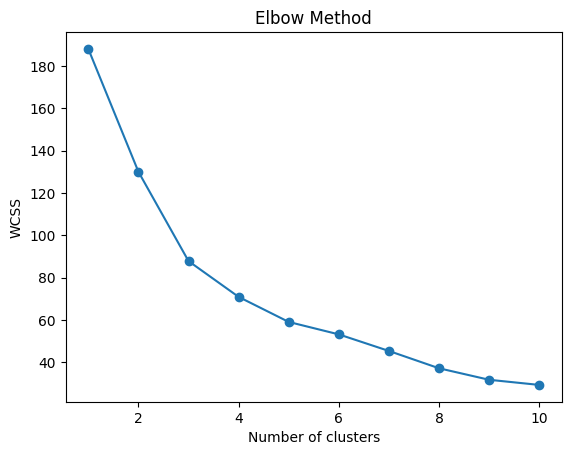

In [7]:
X = h2_df.drop(columns=['Provincias'])
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
    kmeans.fit(X_scaled)
    wcss.append(kmeans.inertia_)

plt.plot(range(1, 11), wcss, marker='o')    
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

Mediante el metodo del codo, interpretamos que el número óptimo de clusters es 3.

In [8]:
k = 3

kmeans = KMeans(n_clusters=k, init='k-means++', max_iter=300, n_init=10, random_state=0)
kmeans.fit(X_scaled)

h2_df['Cluster'] = kmeans.labels_
h2_df['Cluster'] = h2_df['Cluster'].astype('category')

# Visualizacion 3D de los clusters
from plotly import express as px

fig = px.scatter_3d(
    h2_df, x='Indice de viviendas alto consumo', y='Indice de viviendas bajo consumo', z='Indice de viviendas medio consumo',
    color='Cluster', color_continuous_scale='viridis',
    title='Clusters de consumo de viviendas',
    labels={'Indice de viviendas alto consumo': 'Alto consumo', 'Indice de viviendas bajo consumo': 'Bajo consumo', 'Indice de viviendas medio consumo': 'Medio consumo'},
    hover_data={'Provincias': True}
)
fig.show()

Se muestran los distintos clusters obtenidos mediante `K-means` en un gráfico tridimensional en el que los ejes son el índice de viviendas de bajo, medio y alto consumo.

In [9]:
h2_df_cluster = h2_df.copy()
h2_df_cluster.drop(columns=['Indice de viviendas renovables', 'Indice de viviendas bajo consumo','Indice de viviendas medio consumo','Indice de viviendas alto consumo' ], inplace=True)

In [10]:
h2_df_cluster.to_csv(os.path.join(GOLD_DATA_PATH, "data_card_2_df_cluster.csv"), sep = ";", index=False, encoding='utf-8')

### Comparación entre mapa de dispositivos de energía renovable y clusters

In [11]:
X = h2_df.drop(columns=['Provincias','Indice de viviendas renovables', 'Cluster'])
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
    kmeans.fit(X_scaled)
    wcss.append(kmeans.inertia_)


In [12]:
k = 3

kmeans = KMeans(n_clusters=k, init='k-means++', max_iter=300, n_init=10, random_state=0)
kmeans.fit(X_scaled)

h2_df['Cluster'] = kmeans.labels_
h2_df['Cluster'] = h2_df['Cluster'].astype('category')

# Visualizacion 3D de los clusters
from plotly import express as px

fig = px.scatter_3d(
    h2_df, x='Indice de viviendas alto consumo', y='Indice de viviendas bajo consumo', z='Indice de viviendas medio consumo',
    color='Cluster', color_continuous_scale='viridis',
    title='Clusters de consumo de viviendas',
    labels={'Indice de viviendas alto consumo': 'Alto consumo', 'Indice de viviendas bajo consumo': 'Bajo consumo', 'Indice de viviendas medio consumo': 'Medio consumo'},
    hover_data={'Provincias': True}
)
fig.show()

In [13]:
h2_df_cluster = h2_df.copy()
h2_df_cluster.drop(columns=['Indice de viviendas renovables', 'Indice de viviendas bajo consumo','Indice de viviendas medio consumo','Indice de viviendas alto consumo' ], inplace=True)
h2_df_cluster.to_csv(os.path.join(GOLD_DATA_PATH, "data_card_2_df_cluster.csv"), sep = ";", index=False, encoding='utf-8')

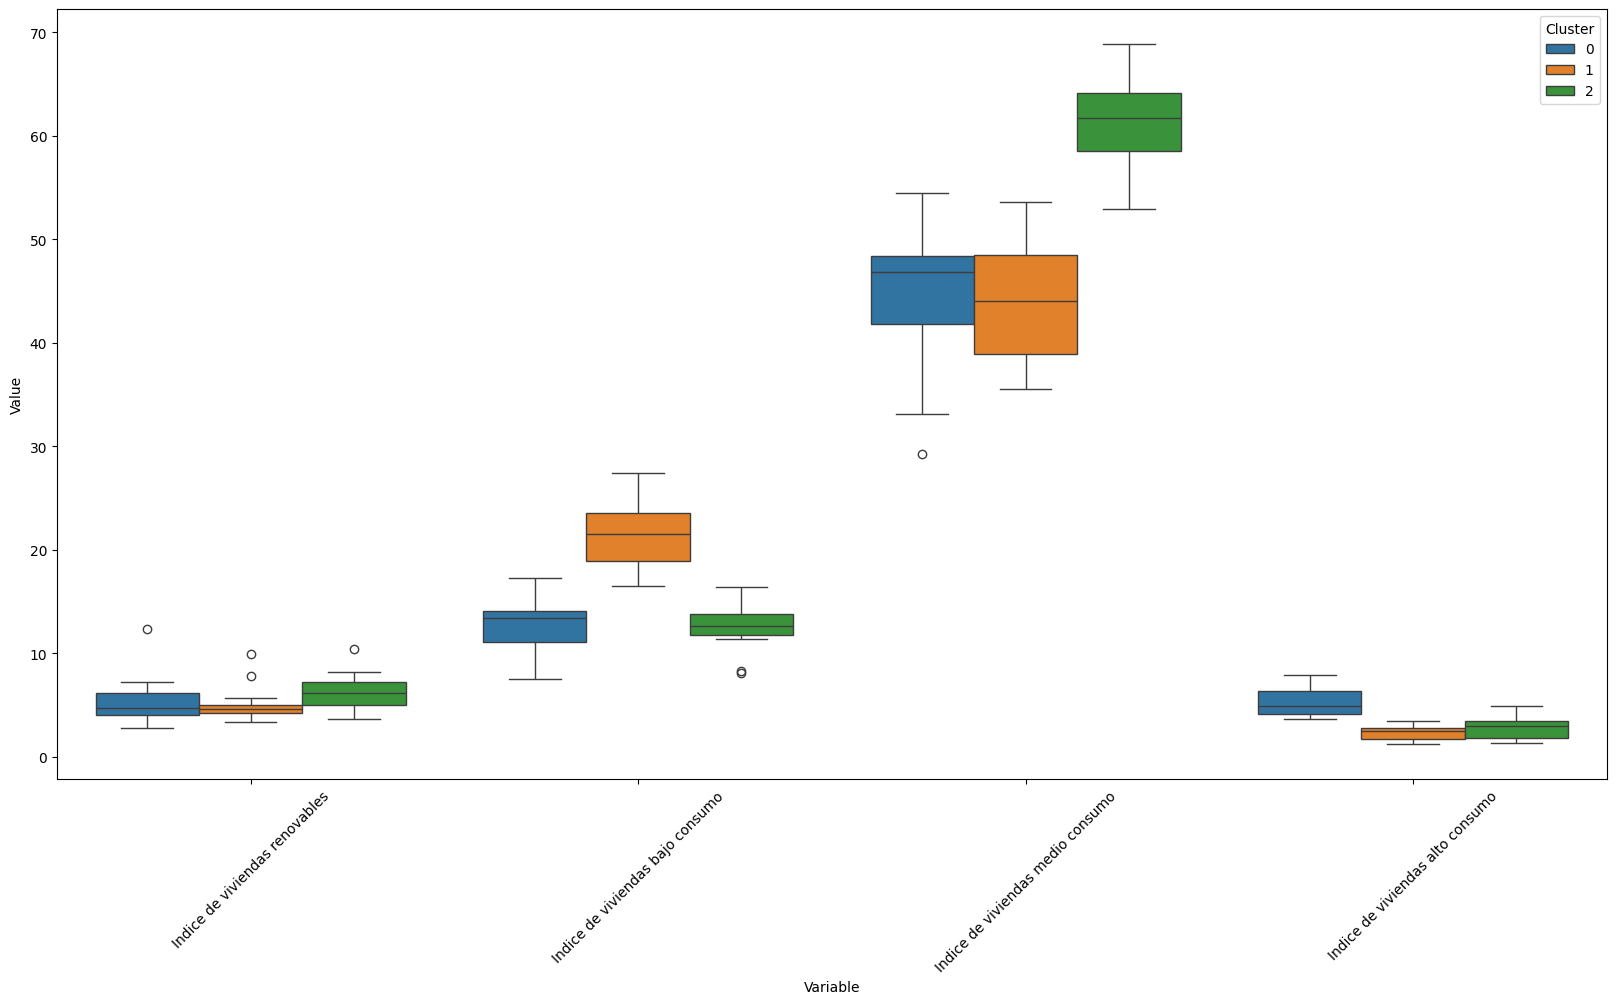

In [14]:
# Plot de las variables entandarizadas por cluster

h2_df_melt = h2_df.melt(id_vars=['Provincias', 'Cluster'], var_name='Variable', value_name='Value')
plt.figure(figsize=(20, 10))
sns.boxplot(x='Variable', y='Value', hue='Cluster', data=h2_df_melt)
plt.xticks(rotation=45)
plt.show()


### Regresión

#### Visualización

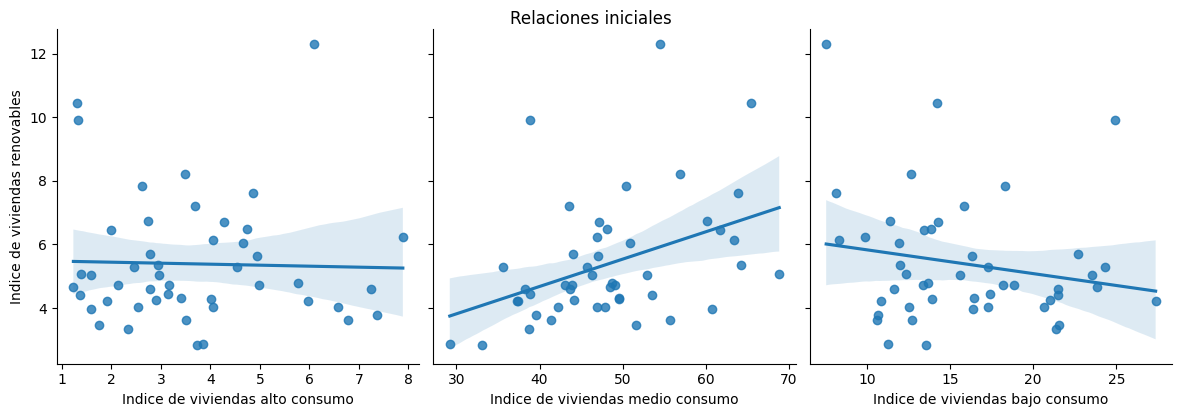

In [15]:
sns.pairplot(h2_df, x_vars=['Indice de viviendas alto consumo', 
                         'Indice de viviendas medio consumo', 
                         'Indice de viviendas bajo consumo'], 
             y_vars='Indice de viviendas renovables', 
             kind='reg', height=4)
plt.suptitle("Relaciones iniciales", y=1.02)
plt.show()

#### Ajuste del modelo de regresión lineal múltiple

In [16]:
X = h2_df.drop(columns=['Provincias','Indice de viviendas renovables'])
y = h2_df['Indice de viviendas renovables']

In [17]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

In [18]:
coeficientes = model.coef_
intercepto = model.intercept_

print(f"Coeficientes: {coeficientes}")
print(f"Intercepto: {intercepto}")

Coeficientes: [-0.04141534  0.09433787 -0.16808385 -0.5324215 ]
Intercepto: 2.6666300343825875


#### Evaluación del modelo

In [19]:
y_pred = model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"R2 Score: {r2}")

Mean Squared Error: 1.3429035322453715
R2 Score: 0.20201415494702313


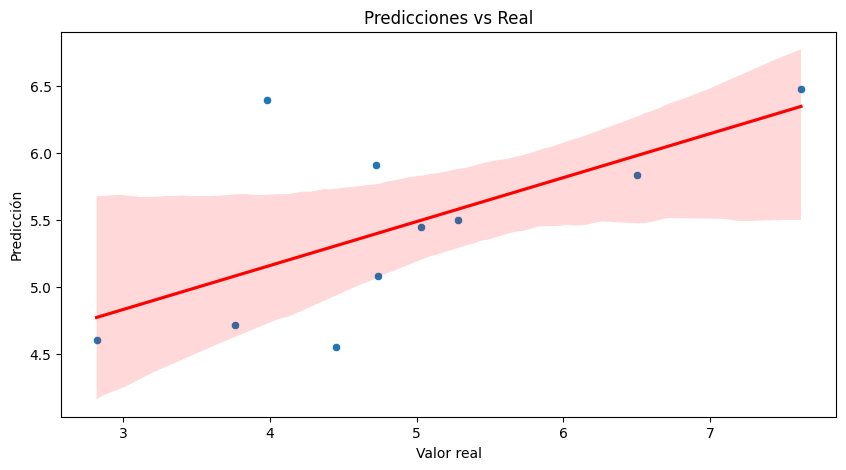

In [20]:
# Plot de las predicciones
plt.figure(figsize=(10, 5))
sns.scatterplot(x=y_test, y=y_pred)
sns.regplot(x=y_test, y=y_pred, scatter=False, color='red',ci=95)
plt.xlabel('Valor real')
plt.ylabel('Predicción')
plt.title('Predicciones vs Real')
plt.show()

### Prueba con Cross-Validation

In [21]:
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression
import numpy as np

# Crear el modelo
model = LinearRegression()

# Crear los datos (asegúrate de que tu DataFrame tenga X e y definidos)
X = h2_df[['Indice de viviendas alto consumo', 
        'Indice de viviendas medio consumo', 
        'Indice de viviendas bajo consumo']].values
y = h2_df['Indice de viviendas renovables'].values

# Configurar K-Fold
kf = KFold(n_splits=4, shuffle=True, random_state=42)

# Listas para almacenar resultados
coef_list = []
intercept_list = []

# Validación cruzada
for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    # Entrenar el modelo en el pliegue actual
    model.fit(X_train, y_train)
    
    # Guardar coeficientes e intercepto
    coef_list.append(model.coef_)
    intercept_list.append(model.intercept_)

# Convertir los resultados a arreglos numpy
coef_array = np.array(coef_list)
intercept_array = np.array(intercept_list)

# Mostrar resultados
print("Coeficientes promedio por característica:", np.mean(coef_array, axis=0))
print("Desviación estándar de los coeficientes:", np.std(coef_array, axis=0))
print("Intercepto promedio:", np.mean(intercept_array))
print("Desviación estándar del intercepto:", np.std(intercept_array))

Coeficientes promedio por característica: [ 0.07416587  0.08786497 -0.00226111]
Desviación estándar de los coeficientes: [0.0425448  0.01733174 0.01902879]
Intercepto promedio: 0.911718845648718
Desviación estándar del intercepto: 0.7707399968704018


**Falta por añadir gráfica**

#### Observaciones

Quizás sea más coherente y riguroso utilizar una regresión lineal para cada tipo de vivienda, es decir, una regresión para observar el comportamiento de cómo afecta el índice de viviendas que utilizan dispositivos de energía renovable según el índice de viviendas de bajo consumo, otra para las de medio consumo y otra de alto consumo. 

El problema de entrenar un modelo de regresión lineal múltiple es que, las variables `Indice de viviendas de alto consumo` e `Indice de viviendas de bajo consumo`, están altamente correlacionadas (-0.695), por lo que tienen mucho mayor peso que `Indice de viviendas de medio consumo` debido a la multicolinealidad.

Sin embargo, si realizamos una regresión lineal simple para cada una de las variables de estudio, obtendremos resultados menos sesgados y más alineados a la hipótesis que queremos validar.

##### Viviendas de alto consumo

In [22]:
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression
import numpy as np

# Crear el modelo
model = LinearRegression()

# Crear los datos (asegúrate de que tu DataFrame tenga X e y definidos)
X = h2_df[['Indice de viviendas alto consumo']].values
y = h2_df['Indice de viviendas renovables'].values

# Configurar K-Fold
kf = KFold(n_splits=4, shuffle=True, random_state=42)

# Listas para almacenar resultados
coef_list = []
intercept_list = []

# Validación cruzada
for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    # Entrenar el modelo en el pliegue actual
    model.fit(X_train, y_train)
    
    # Guardar coeficientes e intercepto
    coef_list.append(model.coef_)
    intercept_list.append(model.intercept_)

# Convertir los resultados a arreglos numpy
coef_array = np.array(coef_list)
intercept_array = np.array(intercept_list)

# Mostrar resultados
print("Coeficientes promedio por característica:", np.mean(coef_array, axis=0))
print("Desviación estándar de los coeficientes:", np.std(coef_array, axis=0))
print("Intercepto promedio:", np.mean(intercept_array))
print("Desviación estándar del intercepto:", np.std(intercept_array))

Coeficientes promedio por característica: [-0.02744394]
Desviación estándar de los coeficientes: [0.08349127]
Intercepto promedio: 5.494850988765113
Desviación estándar del intercepto: 0.22572997417808338


**Falta por añadir gráfica e interpretación de este**

##### Viviendas de medio consumo

In [23]:
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression
import numpy as np

# Crear el modelo
model = LinearRegression()

# Crear los datos (asegúrate de que tu DataFrame tenga X e y definidos)
X = h2_df[['Indice de viviendas medio consumo']].values
y = h2_df['Indice de viviendas renovables'].values

# Configurar K-Fold
kf = KFold(n_splits=4, shuffle=True, random_state=42)

# Listas para almacenar resultados
coef_list = []
intercept_list = []

# Validación cruzada
for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    # Entrenar el modelo en el pliegue actual
    model.fit(X_train, y_train)
    
    # Guardar coeficientes e intercepto
    coef_list.append(model.coef_)
    intercept_list.append(model.intercept_)

# Convertir los resultados a arreglos numpy
coef_array = np.array(coef_list)
intercept_array = np.array(intercept_list)

# Mostrar resultados
print("Coeficientes promedio por característica:", np.mean(coef_array, axis=0))
print("Desviación estándar de los coeficientes:", np.std(coef_array, axis=0))
print("Intercepto promedio:", np.mean(intercept_array))
print("Desviación estándar del intercepto:", np.std(intercept_array))

Coeficientes promedio por característica: [0.08536784]
Desviación estándar de los coeficientes: [0.01885193]
Intercepto promedio: 1.2679755036517835
Desviación estándar del intercepto: 1.0168711374645292


**Falta por añadir gráfica e interpretación de este**

##### Viviendas de bajo consumo

In [24]:
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression
import numpy as np

# Crear el modelo
model = LinearRegression()

# Crear los datos (asegúrate de que tu DataFrame tenga X e y definidos)
X = h2_df[['Indice de viviendas bajo consumo']].values
y = h2_df['Indice de viviendas renovables'].values

# Configurar K-Fold
kf = KFold(n_splits=4, shuffle=True, random_state=42)

# Listas para almacenar resultados
coef_list = []
intercept_list = []

# Validación cruzada
for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    # Entrenar el modelo en el pliegue actual
    model.fit(X_train, y_train)
    
    # Guardar coeficientes e intercepto
    coef_list.append(model.coef_)
    intercept_list.append(model.intercept_)

# Convertir los resultados a arreglos numpy
coef_array = np.array(coef_list)
intercept_array = np.array(intercept_list)

# Mostrar resultados
print("Coeficientes promedio por característica:", np.mean(coef_array, axis=0))
print("Desviación estándar de los coeficientes:", np.std(coef_array, axis=0))
print("Intercepto promedio:", np.mean(intercept_array))
print("Desviación estándar del intercepto:", np.std(intercept_array))

Coeficientes promedio por característica: [-0.07509406]
Desviación estándar de los coeficientes: [0.02137335]
Intercepto promedio: 6.58433410061974
Desviación estándar del intercepto: 0.40946622435249996


**Falta por añadir gráfica e interpretación de este**